<a href="https://colab.research.google.com/github/gandalf1819/SF-Opioid-Crisis/blob/master/SF_drug_knn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import numpy as np
import pandas as pd
import os

In [0]:
d_crime = pd.read_csv("/content/gdrive/My Drive/SF dataset/Police_Department_Incident_Reports__Historical_2003_to_May_2018.csv")
d_crime.columns

Index(['IncidntNum', 'Category', 'Descript', 'DayOfWeek', 'Date', 'Time',
       'PdDistrict', 'Resolution', 'Address', 'X', 'Y', 'Location', 'PdId'],
      dtype='object')

In [0]:
np.random.seed(100)
random_d_crime=d_crime.sample(2215024)
train_size=int(0.67 *2215024)
train_df=random_d_crime[:train_size]
test_df=random_d_crime[train_size:]

In [0]:
train_df['DateTime'] = train_df.Date + " " + train_df.Time
train_df['DateTime'] = pd.to_datetime(train_df['DateTime'], format='%m/%d/%Y %H:%M')

test_df['DateTime'] = test_df.Date + " " + test_df.Time
test_df['DateTime'] = pd.to_datetime(test_df['DateTime'], format='%m/%d/%Y %H:%M')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

In [0]:
train_df.columns

Index(['IncidntNum', 'Category', 'Descript', 'DayOfWeek', 'Date', 'Time',
       'PdDistrict', 'Resolution', 'Address', 'X', 'Y', 'Location', 'PdId',
       'DateTime'],
      dtype='object')

In [0]:
test_df.columns

Index(['IncidntNum', 'Category', 'Descript', 'DayOfWeek', 'Date', 'Time',
       'PdDistrict', 'Resolution', 'Address', 'X', 'Y', 'Location', 'PdId',
       'DateTime'],
      dtype='object')

In [0]:
train_df.shape

(1484066, 14)

In [0]:
target = train_df["Category"].unique()
print(target.shape)
target

(39,)


array(['SUSPICIOUS OCC', 'LARCENY/THEFT', 'ASSAULT', 'NON-CRIMINAL',
       'VEHICLE THEFT', 'WARRANTS', 'BURGLARY', 'OTHER OFFENSES',
       'DRUG/NARCOTIC', 'MISSING PERSON', 'FRAUD', 'ROBBERY', 'VANDALISM',
       'KIDNAPPING', 'SEX OFFENSES, FORCIBLE', 'WEAPON LAWS',
       'DISORDERLY CONDUCT', 'RECOVERED VEHICLE', 'DRUNKENNESS',
       'SECONDARY CODES', 'PROSTITUTION', 'EMBEZZLEMENT', 'TRESPASS',
       'RUNAWAY', 'STOLEN PROPERTY', 'FORGERY/COUNTERFEITING',
       'LOITERING', 'ARSON', 'DRIVING UNDER THE INFLUENCE', 'LIQUOR LAWS',
       'EXTORTION', 'SUICIDE', 'FAMILY OFFENSES', 'BAD CHECKS', 'BRIBERY',
       'GAMBLING', 'SEX OFFENSES, NON FORCIBLE',
       'PORNOGRAPHY/OBSCENE MAT', 'TREA'], dtype=object)

In [0]:
X = train_df[['DateTime', 'DayOfWeek', 'PdDistrict', 'X', 'Y']]
X.head()

,DateTime,DayOfWeek,PdDistrict,X,Y
1618683,2006-10-13 23:13:00,Friday,CENTRAL,-122.406504,37.797678
1303833,2012-06-30 17:40:00,Saturday,MISSION,-122.415308,37.765316
38943,2014-07-06 22:20:00,Sunday,CENTRAL,-122.423658,37.805285
1737093,2008-10-18 10:30:00,Saturday,BAYVIEW,-122.399679,37.766695
1490803,2010-04-10 17:30:00,Saturday,TENDERLOIN,-122.414645,37.786069


In [0]:
y = train_df.iloc[:, 1]
y.head()

1618683    SUSPICIOUS OCC
1303833     LARCENY/THEFT
38943       LARCENY/THEFT
1737093     LARCENY/THEFT
1490803           ASSAULT
Name: Category, dtype: object

In [0]:
def preprocess_data(dataset):
    dataset['DateTime'] = pd.to_datetime(dataset['DateTime'])
    dataset['Month'] = dataset.DateTime.apply(lambda x: x.month)
    dataset['Day'] = dataset.DateTime.apply(lambda x: x.day)
    dataset['Hour'] = dataset.DateTime.apply(lambda x: x.hour)
    dataset['Minute'] = dataset.DateTime.apply(lambda x: x.minute)
    dataset = dataset.drop('DateTime', 1)
    
    dataset = pd.get_dummies(data=dataset, columns=['DayOfWeek', 'PdDistrict'])
    return dataset

In [0]:
X = preprocess_data(X)
X.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



,X,Y,Month,Day,Hour,Minute,DayOfWeek_Friday,DayOfWeek_Monday,DayOfWeek_Saturday,DayOfWeek_Sunday,DayOfWeek_Thursday,DayOfWeek_Tuesday,DayOfWeek_Wednesday,PdDistrict_BAYVIEW,PdDistrict_CENTRAL,PdDistrict_INGLESIDE,PdDistrict_MISSION,PdDistrict_NORTHERN,PdDistrict_PARK,PdDistrict_RICHMOND,PdDistrict_SOUTHERN,PdDistrict_TARAVAL,PdDistrict_TENDERLOIN
1618683,-122.406504,37.797678,10,13,23,13,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1303833,-122.415308,37.765316,6,30,17,40,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
38943,-122.423658,37.805285,7,6,22,20,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0
1737093,-122.399679,37.766695,10,18,10,30,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1490803,-122.414645,37.786069,4,10,17,30,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [0]:
from sklearn.preprocessing import LabelEncoder
y = y.to_frame()
le = LabelEncoder()
y["Category"] = le.fit_transform(y["Category"])
print(y.head())

         Category
1618683        32
1303833        16
38943          16
1737093        16
1490803         1


In [0]:
keys = le.classes_
values = le.transform(le.classes_)
dictionary = dict(zip(keys, values))
print(dictionary)

{'ARSON': 0, 'ASSAULT': 1, 'BAD CHECKS': 2, 'BRIBERY': 3, 'BURGLARY': 4, 'DISORDERLY CONDUCT': 5, 'DRIVING UNDER THE INFLUENCE': 6, 'DRUG/NARCOTIC': 7, 'DRUNKENNESS': 8, 'EMBEZZLEMENT': 9, 'EXTORTION': 10, 'FAMILY OFFENSES': 11, 'FORGERY/COUNTERFEITING': 12, 'FRAUD': 13, 'GAMBLING': 14, 'KIDNAPPING': 15, 'LARCENY/THEFT': 16, 'LIQUOR LAWS': 17, 'LOITERING': 18, 'MISSING PERSON': 19, 'NON-CRIMINAL': 20, 'OTHER OFFENSES': 21, 'PORNOGRAPHY/OBSCENE MAT': 22, 'PROSTITUTION': 23, 'RECOVERED VEHICLE': 24, 'ROBBERY': 25, 'RUNAWAY': 26, 'SECONDARY CODES': 27, 'SEX OFFENSES, FORCIBLE': 28, 'SEX OFFENSES, NON FORCIBLE': 29, 'STOLEN PROPERTY': 30, 'SUICIDE': 31, 'SUSPICIOUS OCC': 32, 'TREA': 33, 'TRESPASS': 34, 'VANDALISM': 35, 'VEHICLE THEFT': 36, 'WARRANTS': 37, 'WEAPON LAWS': 38}


In [0]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [0]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train.values.ravel())

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [0]:
# y_pred = knn.predict(X_test)
from sklearn.metrics import accuracy_score, recall_score

accuracy = accuracy_score(y_test, y_pred)
print ("Accuracy for KNN: %.2f%%" % (accuracy * 100.0))

Accuracy for KNN: 61.54%


In [0]:
# Computer precision score across multiple classes
from sklearn.metrics import precision_score

precision = precision_score(y_test, y_pred, average='micro')
print("Precision for KNN: %.2f%%" % precision)

Precision for KNN: 0.69%


In [0]:
# Compute recall over multiple classes
from sklearn.metrics import recall_score

recall = recall_score(y_test, y_pred, average='micro')
print("Recall for KNN: %.2f%%" % recall)

Recall for KNN: 0.64%


In [0]:
# Compute f1 score across multiple classes
from sklearn.metrics import f1_score

f1 = f1_score(y_test, y_pred, average='micro')
print("F1 score for KNN: %.2f%%" % f1)

F1 score for KNN: 0.67%


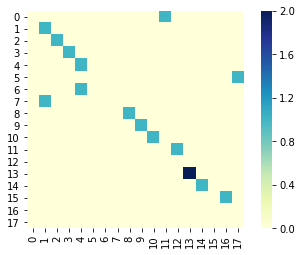

In [0]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns  
cm = confusion_matrix(y_test, y_pred)
cm = pd.DataFrame(cm)
sns.heatmap(cm, cmap="YlGnBu", square=True)

In [0]:
test_data = preprocess_data(test_df)
test_data.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



,IncidntNum,Category,Descript,Date,Time,Resolution,Address,X,Y,Location,PdId,Month,Day,Hour,Minute,DayOfWeek_Friday,DayOfWeek_Monday,DayOfWeek_Saturday,DayOfWeek_Sunday,DayOfWeek_Thursday,DayOfWeek_Tuesday,DayOfWeek_Wednesday,PdDistrict_BAYVIEW,PdDistrict_CENTRAL,PdDistrict_INGLESIDE,PdDistrict_MISSION,PdDistrict_NORTHERN,PdDistrict_PARK,PdDistrict_RICHMOND,PdDistrict_SOUTHERN,PdDistrict_TARAVAL,PdDistrict_TENDERLOIN
1041060,100505055,LARCENY/THEFT,GRAND THEFT FROM PERSON,05/31/2010,13:30,NONE,VANNESS AV / BUSH ST,-122.421949,37.788488,POINT (-122.421949487547 37.7884881521135),10050505506153,5,31,13,30,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
578101,51217525,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,10/14/2005,13:00,NONE,2600 Block of MISSION ST,-122.418600,37.754626,POINT (-122.41860030589 37.7546255872838),5121752506244,10,14,13,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
324260,81013597,PROSTITUTION,PIMPING,09/24/2008,01:39,"ARREST, CITED",LARKIN ST / SUTTER ST,-122.418468,37.787965,POINT (-122.418467747931 37.7879652569797),8101359713030,9,24,1,39,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0
1404604,31205829,VEHICLE THEFT,STOLEN AUTOMOBILE,10/12/2003,23:00,NONE,900 Block of HAMILTON ST,-122.406894,37.719578,POINT (-122.406893832735 37.7195778124637),3120582907021,10,12,23,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0
1357958,90022202,NON-CRIMINAL,TARASOFF REPORT,01/07/2009,10:42,NONE,2200 Block of GEARY BL,-122.440341,37.783324,POINT (-122.440341074545 37.7833242481047),9002220215095,1,7,10,42,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0


In [0]:
# test_data = test_data.drop('PdId', 1)
# test_data = test_data.drop('Address', 1)
# test_data = test_data.drop('Date', 1)
# test_data = test_data.drop('Time', 1)
# test_data = test_data.drop('Location', 1)

In [0]:
test_data.head()

,IncidntNum,Category,Descript,Resolution,X,Y,Month,Day,Hour,Minute,DayOfWeek_Friday,DayOfWeek_Monday,DayOfWeek_Saturday,DayOfWeek_Sunday,DayOfWeek_Thursday,DayOfWeek_Tuesday,DayOfWeek_Wednesday,PdDistrict_BAYVIEW,PdDistrict_CENTRAL,PdDistrict_INGLESIDE,PdDistrict_MISSION,PdDistrict_NORTHERN,PdDistrict_PARK,PdDistrict_RICHMOND,PdDistrict_SOUTHERN,PdDistrict_TARAVAL,PdDistrict_TENDERLOIN
1041060,100505055,LARCENY/THEFT,GRAND THEFT FROM PERSON,NONE,-122.421949,37.788488,5,31,13,30,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
578101,51217525,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,NONE,-122.418600,37.754626,10,14,13,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
324260,81013597,PROSTITUTION,PIMPING,"ARREST, CITED",-122.418468,37.787965,9,24,1,39,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0
1404604,31205829,VEHICLE THEFT,STOLEN AUTOMOBILE,NONE,-122.406894,37.719578,10,12,23,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0
1357958,90022202,NON-CRIMINAL,TARASOFF REPORT,NONE,-122.440341,37.783324,1,7,10,42,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0


In [0]:
y_pred_proba = knn.predict_proba(test_data)

ValueError: ignored

In [0]:
colmn = ["ARSON","ASSAULT","BAD CHECKS","BRIBERY","BURGLARY","DISORDERLY CONDUCT","DRIVING UNDER THE INFLUENCE","DRUG/NARCOTIC","DRUNKENNESS","EMBEZZLEMENT","EXTORTION","FAMILY OFFENSES","FORGERY/COUNTERFEITING","FRAUD","GAMBLING","KIDNAPPING","LARCENY/THEFT","LIQUOR LAWS","LOITERING","MISSING PERSON","NON-CRIMINAL","OTHER OFFENSES","PORNOGRAPHY/OBSCENE MAT","PROSTITUTION","RECOVERED VEHICLE","ROBBERY","RUNAWAY","SECONDARY CODES","SEX OFFENSES FORCIBLE","SEX OFFENSES NON FORCIBLE","STOLEN PROPERTY","SUICIDE","SUSPICIOUS OCC","TREA","TRESPASS","VANDALISM","VEHICLE THEFT","WARRANTS","WEAPON LAWS"]
result = pd.DataFrame(y_pred_proba, columns=colmn)

In [0]:
result.head()

,ARSON,ASSAULT,BAD CHECKS,BRIBERY,BURGLARY,DISORDERLY CONDUCT,DRIVING UNDER THE INFLUENCE,DRUG/NARCOTIC,DRUNKENNESS,EMBEZZLEMENT,EXTORTION,FAMILY OFFENSES,FORGERY/COUNTERFEITING,FRAUD,GAMBLING,KIDNAPPING,LARCENY/THEFT,LIQUOR LAWS,LOITERING,MISSING PERSON,NON-CRIMINAL,OTHER OFFENSES,PORNOGRAPHY/OBSCENE MAT,PROSTITUTION,RECOVERED VEHICLE,ROBBERY,RUNAWAY,SECONDARY CODES,SEX OFFENSES FORCIBLE,SEX OFFENSES NON FORCIBLE,STOLEN PROPERTY,SUICIDE,SUSPICIOUS OCC,TREA,TRESPASS,VANDALISM,VEHICLE THEFT,WARRANTS,WEAPON LAWS
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.6,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0
1,0.0,0.4,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.6,0.0,0.0
4,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.2,0.0,0.0,0.0,0.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
